# RNN, LSTM, and GRU for Air Quality Prediction

## Dataset
* UCI Air Quality dataset
* https://archive.ics.uci.edu/dataset/360/air+quality
* https://archive.ics.uci.edu/static/public/360/air+quality.zip

* http://makeenv2.azri.xyz:5053/

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from zipfile import ZipFile

In [3]:
df = pd.read_csv("AirQualityUCI.csv", sep=';', decimal=',', na_values=-200)

In [4]:
df.head(3)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN


In [5]:
# Drop last two columns (unnamed) and rows with NaN
df = df.iloc[:, :-2].dropna()
df = df.reset_index(drop=True)
df.head(3)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


## Data Pipeline

In [6]:
TIMESTEPS = 24  # Number of past hours to use for prediction
TARGET = "CO(GT)"

features = df.columns.drop([TARGET, "Date", "Time"])
data = df[features].astype(float).values
target = df[TARGET].astype(float).values

In [7]:

# Take this list of [feature+ target], turn it into a dataset tensorflow 
# can understand, and make sure every value in it 
# is in the right format(float32) for the model to use.
def create_tf_dataset(features, target, timesteps):
    ds = tf.data.Dataset.from_tensor_slices((features, target))
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    
    # Normalize using tf.data (fit on all data, but in practice fit only on train)
    # norm = tf.keras.layers.Normalization()
    # norm.adapt(features)    
    # ds = ds.map(lambda x, y: (norm(x), y))
    
    # Recombine features and target for windowing
    ds = tf.data.Dataset.from_tensor_slices(tf.concat([features, target.reshape(-1, 1)], axis=1))
    ds = ds.window(timesteps + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(timesteps + 1))
    ds = ds.map(lambda window: (window[:-1, :-1], window[-1, -1]))
    return ds

#Take a sequence of features and targets, turn them into sliding window 
# of length [timesteps + 1], and split each into [input sequence, target value] 
#pairs for time series prediction.

In [8]:
BATCH_SIZE = 32
dataset = create_tf_dataset(data, target, TIMESTEPS)
dataset = dataset.batch(1)  # Each element is a single (X, y) pair

In [9]:
# Split using take and skip

#counts how many items [batches oe window] are in dataset, 
# loop through the dataset uing a generator and adds 1 each time
#you get the total number of elements in the dataset
total = sum(1 for _ in dataset) 
train_size = int(0.8 * total)
# will takes 80% of the dataset, if the dataset is grouped,
#  it flattens it back into individual elements. or groupes the individual
#  element into new batches for training. improve preformave by loading the 
# next batch in the background while the current one is being processed
train_ds = dataset.take(train_size).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# same idea as above , but skip first 80% and use remaning 20% for testing
test_ds = dataset.skip(train_size).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
# the code grabs one batch from the training data and prints the shape
#of a single input sample, which helps you correctly define you model's
#input layer

for x_batch, y_batch in train_ds.take(1):
    input_shape = x_batch.shape[1:]
    print("Input shape:", input_shape)

Input shape: (24, 12)


## Model Architecture

1. Simple RNN
2. LSTM
3. GRU

In [11]:
from keras import layers, models

In [12]:
def build_simple_rnn(input_shape):
    model = models.Sequential([
        layers.SimpleRNN(32, activation='relu', input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
def build_lstm(input_shape):
    model = models.Sequential([
        layers.LSTM(32, activation='tanh', input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
def build_gru(input_shape):
    model = models.Sequential([
        layers.GRU(32, activation='tanh', input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [15]:
# Use input_shape from tf.data pipeline
rnn_model = build_simple_rnn(input_shape)
rnn_model.summary()
lstm_model = build_lstm(input_shape)
lstm_model.summary()
gru_model = build_gru(input_shape)
gru_model.summary()

C:\Users\Hibatullah\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,793 (22.63 KB)

 Trainable params: 5,793 (22.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,449 (17.38 KB)

 Trainable params: 4,449 (17.38 KB)

 Non-trainable params: 0 (0.00 B)

## Training and Evaluation

In [17]:
EPOCHS = 20
# verbose: how much training information gets printed to the console while
#your model is training
def train_and_evaluate(model, name):
    history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose=0)
    return history

# Collect histories
rnn_history = train_and_evaluate(rnn_model, "RNN")
lstm_history = train_and_evaluate(lstm_model, "LSTM")
gru_history = train_and_evaluate(gru_model, "GRU")

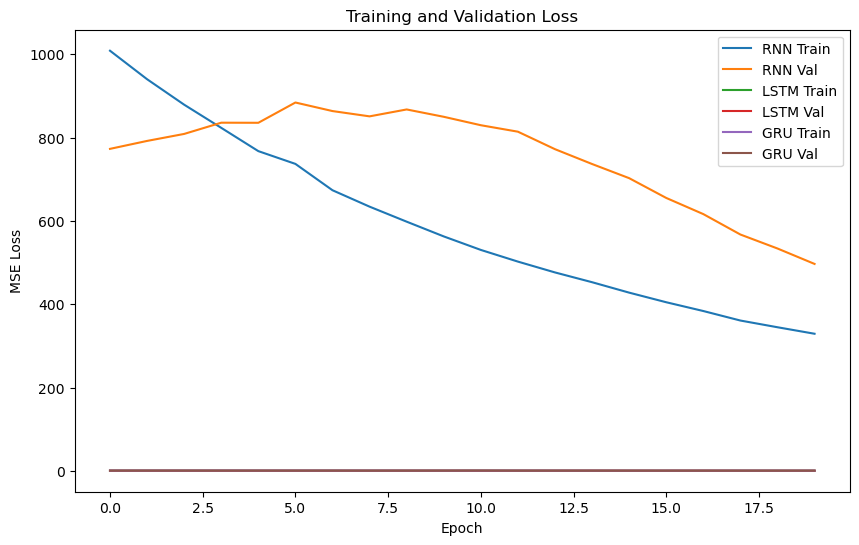

In [18]:
# Plot all losses together
plt.figure(figsize=(10,6))
plt.plot(rnn_history.history['loss'], label='RNN Train')
plt.plot(rnn_history.history['val_loss'], label='RNN Val')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.plot(gru_history.history['loss'], label='GRU Train')
plt.plot(gru_history.history['val_loss'], label='GRU Val')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## Model Performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


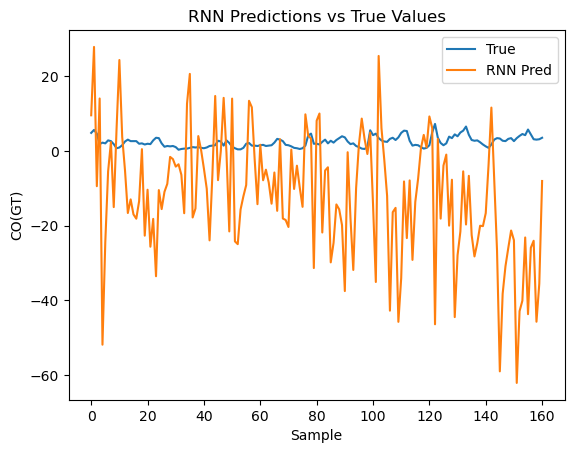

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


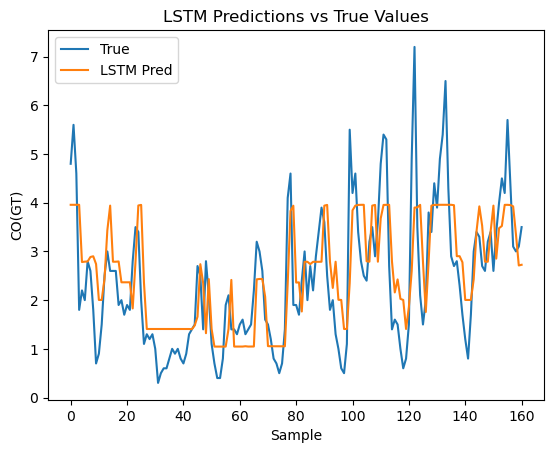

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


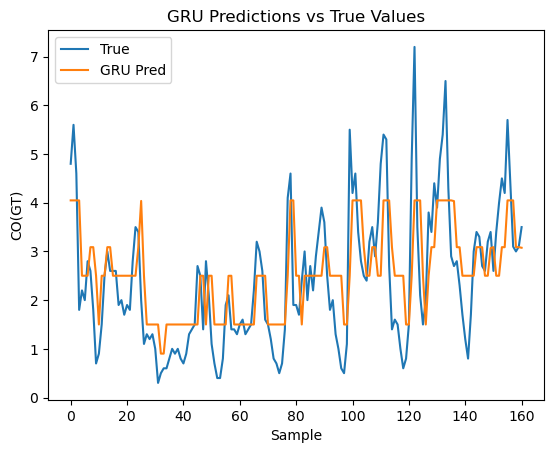

In [19]:
def plot_predictions(model, test_ds, y_true, name):
    preds = np.concatenate([model.predict(x) for x, _ in test_ds])
    y_true = np.concatenate([y for _, y in test_ds])
    plt.plot(y_true[:200], label="True")
    plt.plot(preds[:200], label=f"{name} Pred")
    plt.title(f"{name} Predictions vs True Values")
    plt.xlabel("Sample")
    plt.ylabel("CO(GT)")
    plt.legend()
    plt.show()

plot_predictions(rnn_model, test_ds, None, "RNN")
plot_predictions(lstm_model, test_ds, None, "LSTM")
plot_predictions(gru_model, test_ds, None, "GRU")

## Effect of Different Timesteps

In [20]:
total

803

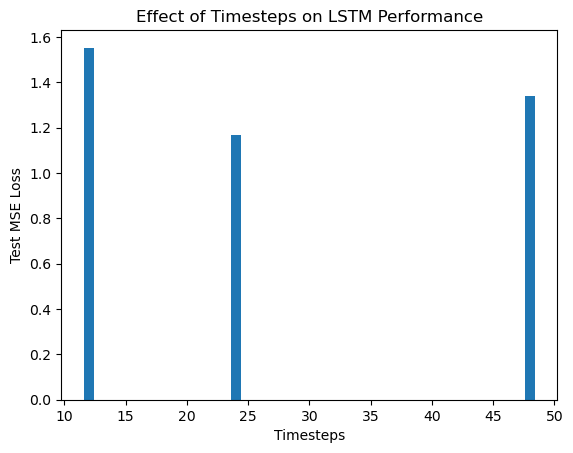

In [21]:
timesteps_list = [12, 24, 48]
results = {}

for ts in timesteps_list:
    dataset = create_tf_dataset(data, target, ts)
    dataset = dataset.batch(1)
    total = sum(1 for _ in dataset)
    train_size = int(0.8 * total)
    train_ds = dataset.take(train_size).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds = dataset.skip(train_size).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    for x_batch, _ in train_ds.take(1):
        input_shape = x_batch.shape[1:]
    model = build_lstm(input_shape)
    history = model.fit(train_ds, validation_data=test_ds, epochs=10, verbose=0)
    loss = model.evaluate(test_ds, verbose=0)
    results[ts] = loss

plt.bar(results.keys(), results.values())
plt.xlabel("Timesteps")
plt.ylabel("Test MSE Loss")
plt.title("Effect of Timesteps on LSTM Performance")
plt.show()